
# This is a fork of Alex Shonenkov kernel with TTA added
[[Train + Inference] GPU Baseline](https://www.kaggle.com/shonenkov/train-inference-gpu-baseline)

# Alaska2 Baseline PyTorch

Hi everyone!

My name is Alex Shonenkov, I am DL/NLP/CV/TS research engineer. Especially I am in Love with NLP & DL.

I would like to share with you my starter pipeline for solving this competition :)

# Main Ideas

- 4 Classes
- GroupKFold splitting
- Class Balance
- Flips
- Label Smoothing
- EfficientNetB2
- ReduceLROnPlateau

# Dependencies

In [36]:
# !pip install -q efficientnet_pytorch > /dev/null

In [37]:
from glob import glob
from sklearn.model_selection import GroupKFold
import cv2
from skimage import io
import torch
from torch import nn
import os
from datetime import datetime
import time
import random
import cv2
import pandas as pd
import numpy as np
import albumentations as A
import matplotlib.pyplot as plt
from albumentations.pytorch.transforms import ToTensorV2
from torch.utils.data import Dataset,DataLoader
from torch.utils.data.sampler import SequentialSampler, RandomSampler
import sklearn

SEED = 512

def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = True

seed_everything(SEED)

# GroupKFold splitting

I think group splitting by image_name is really important for correct validation in this competition ;) 

In [38]:
%%time

dataset = []

for label, kind in enumerate(['Cover', 'JMiPOD', 'JUNIWARD', 'UERD']):
    for path in glob('alaska2-image-steganalysis/Cover/*.jpg'):
        dataset.append({
            'kind': kind,
            'image_name': path.split('/')[-1],
            'label': label
        })

random.shuffle(dataset)
dataset = pd.DataFrame(dataset)

gkf = GroupKFold(n_splits=32)

dataset.loc[:, 'fold'] = 0
for fold_number, (train_index, val_index) in enumerate(gkf.split(X=dataset.index, y=dataset['label'], groups=dataset['image_name'])):
    dataset.loc[dataset.iloc[val_index].index, 'fold'] = fold_number

CPU times: user 2 s, sys: 117 ms, total: 2.11 s
Wall time: 2.11 s


In any case original dataframe with splitting:

In [39]:
# dataset = pd.read_csv('../input/alaska2-public-baseline/groupkfold_by_shonenkov.csv')

# Simple Augs: Flips

In [40]:
def get_train_transforms():
    return A.Compose([
            A.HorizontalFlip(p=0.5),
            A.VerticalFlip(p=0.5),
            A.Resize(height=512, width=512, p=1.0),
            ToTensorV2(p=1.0),
        ], p=1.0)

def get_valid_transforms():
    return A.Compose([
            A.Resize(height=512, width=512, p=1.0),
            ToTensorV2(p=1.0),
        ], p=1.0)

# Dataset

In [41]:
DATA_ROOT_PATH = 'alaska2-image-steganalysis'

def onehot(size, target):
    vec = torch.zeros(size, dtype=torch.float32)
    vec[target] = 1.
    return vec

class DatasetRetriever(Dataset):

    def __init__(self, kinds, image_names, labels, transforms=None):
        super().__init__()
        self.kinds = kinds
        self.image_names = image_names
        self.labels = labels
        self.transforms = transforms

    def __getitem__(self, index: int):
        kind, image_name, label = self.kinds[index], self.image_names[index], self.labels[index]
        image = cv2.imread(f'{DATA_ROOT_PATH}/{kind}/{image_name}', cv2.IMREAD_COLOR)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB).astype(np.float32)
        image /= 255.0
        if self.transforms:
            sample = {'image': image}
            sample = self.transforms(**sample)
            image = sample['image']
            
        target = onehot(4, label)
        return image, target

    def __len__(self) -> int:
        return self.image_names.shape[0]

    def get_labels(self):
        return list(self.labels)

In [42]:
fold_number = 0

# train_dataset = DatasetRetriever(
#     kinds=dataset[dataset['fold'] != fold_number].kind.values,
#     image_names=dataset[dataset['fold'] != fold_number].image_name.values,
#     labels=dataset[dataset['fold'] != fold_number].label.values,
#     transforms=get_train_transforms(),
# )

validation_dataset = DatasetRetriever(
    kinds=dataset[dataset['fold'] == fold_number].kind.values,
    image_names=dataset[dataset['fold'] == fold_number].image_name.values,
    labels=dataset[dataset['fold'] == fold_number].label.values,
    transforms=get_valid_transforms(),
)

In [43]:
# image, target = train_dataset[0]
# numpy_image = image.permute(1,2,0).cpu().numpy()

# fig, ax = plt.subplots(1, 1, figsize=(16, 8))
    
# ax.set_axis_off()
# ax.imshow(numpy_image);

# Metrics

In [44]:
from sklearn import metrics

class AverageMeter(object):
    """Computes and stores the average and current value"""
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count
        
        
def alaska_weighted_auc(y_true, y_valid):
    """
    https://www.kaggle.com/anokas/weighted-auc-metric-updated
    """
    tpr_thresholds = [0.0, 0.4, 1.0]
    weights = [2, 1]

    fpr, tpr, thresholds = metrics.roc_curve(y_true, y_valid, pos_label=1)

    # size of subsets
    areas = np.array(tpr_thresholds[1:]) - np.array(tpr_thresholds[:-1])

    # The total area is normalized by the sum of weights such that the final weighted AUC is between 0 and 1.
    normalization = np.dot(areas, weights)

    competition_metric = 0
    for idx, weight in enumerate(weights):
        y_min = tpr_thresholds[idx]
        y_max = tpr_thresholds[idx + 1]
        mask = (y_min < tpr) & (tpr < y_max)
        # pdb.set_trace()

        x_padding = np.linspace(fpr[mask][-1], 1, 100)

        x = np.concatenate([fpr[mask], x_padding])
        y = np.concatenate([tpr[mask], [y_max] * len(x_padding)])
        y = y - y_min  # normalize such that curve starts at y=0
        score = metrics.auc(x, y)
        submetric = score * weight
        best_subscore = (y_max - y_min) * weight
        competition_metric += submetric

    return competition_metric / normalization
        
class RocAucMeter(object):
    def __init__(self):
        self.reset()

    def reset(self):
        self.y_true = np.array([0,1])
        self.y_pred = np.array([0.5,0.5])
        self.score = 0

    def update(self, y_true, y_pred):
        y_true = y_true.cpu().numpy().argmax(axis=1).clip(min=0, max=1).astype(int)
        y_pred = 1 - nn.functional.softmax(y_pred, dim=1).data.cpu().numpy()[:,0]
        self.y_true = np.hstack((self.y_true, y_true))
        self.y_pred = np.hstack((self.y_pred, y_pred))
        self.score = alaska_weighted_auc(self.y_true, self.y_pred)
    
    @property
    def avg(self):
        return self.score

# Label Smoothing

In [45]:
class LabelSmoothing(nn.Module):
    def __init__(self, smoothing = 0.05):
        super(LabelSmoothing, self).__init__()
        self.confidence = 1.0 - smoothing
        self.smoothing = smoothing

    def forward(self, x, target):
        if self.training:
            x = x.float()
            target = target.float()
            logprobs = torch.nn.functional.log_softmax(x, dim = -1)

            nll_loss = -logprobs * target
            nll_loss = nll_loss.sum(-1)
    
            smooth_loss = -logprobs.mean(dim=-1)

            loss = self.confidence * nll_loss + self.smoothing * smooth_loss

            return loss.mean()
        else:
            return torch.nn.functional.cross_entropy(x, target)

# Fitter

In [46]:
import warnings

warnings.filterwarnings("ignore")

class Fitter:
    
    def __init__(self, model, device, config):
        self.config = config
        self.epoch = 0
        
        self.base_dir = './'
        self.log_path = f'{self.base_dir}/log.txt'
        self.best_summary_loss = 10**5

        self.model = model
        self.device = device

        param_optimizer = list(self.model.named_parameters())
        no_decay = ['bias', 'LayerNorm.bias', 'LayerNorm.weight']
        optimizer_grouped_parameters = [
            {'params': [p for n, p in param_optimizer if not any(nd in n for nd in no_decay)], 'weight_decay': 0.001},
            {'params': [p for n, p in param_optimizer if any(nd in n for nd in no_decay)], 'weight_decay': 0.0}
        ] 

        self.optimizer = torch.optim.AdamW(self.model.parameters(), lr=config.lr)
        self.scheduler = config.SchedulerClass(self.optimizer, **config.scheduler_params)
        self.criterion = LabelSmoothing().to(self.device)
        self.log(f'Fitter prepared. Device is {self.device}')

    def fit(self, train_loader, validation_loader):
        for e in range(self.config.n_epochs):
            if self.config.verbose:
                lr = self.optimizer.param_groups[0]['lr']
                timestamp = datetime.utcnow().isoformat()
                self.log(f'\n{timestamp}\nLR: {lr}')

            t = time.time()
            summary_loss, final_scores = self.train_one_epoch(train_loader)

            self.log(f'[RESULT]: Train. Epoch: {self.epoch}, summary_loss: {summary_loss.avg:.5f}, final_score: {final_scores.avg:.5f}, time: {(time.time() - t):.5f}')
            self.save(f'{self.base_dir}/last-checkpoint.bin')

            t = time.time()
            summary_loss, final_scores = self.validation(validation_loader)

            self.log(f'[RESULT]: Val. Epoch: {self.epoch}, summary_loss: {summary_loss.avg:.5f}, final_score: {final_scores.avg:.5f}, time: {(time.time() - t):.5f}')
            if summary_loss.avg < self.best_summary_loss:
                self.best_summary_loss = summary_loss.avg
                self.model.eval()
                self.save(f'{self.base_dir}/best-checkpoint-{str(self.epoch).zfill(3)}epoch.bin')
                for path in sorted(glob(f'{self.base_dir}/best-checkpoint-*epoch.bin'))[:-3]:
                    os.remove(path)

            if self.config.validation_scheduler:
                self.scheduler.step(metrics=summary_loss.avg)

            self.epoch += 1

    def validation(self, val_loader):
        self.model.eval()
        summary_loss = AverageMeter()
        final_scores = RocAucMeter()
        t = time.time()
        for step, (images, targets) in enumerate(val_loader):
            if self.config.verbose:
                if step % self.config.verbose_step == 0:
                    print(
                        f'Val Step {step}/{len(val_loader)}, ' + \
                        f'summary_loss: {summary_loss.avg:.5f}, final_score: {final_scores.avg:.5f}, ' + \
                        f'time: {(time.time() - t):.5f}', end='\r'
                    )
            with torch.no_grad():
                targets = targets.to(self.device).float()
                batch_size = images.shape[0]
                images = images.to(self.device).float()
                outputs = self.model(images)
                loss = self.criterion(outputs, targets)
                final_scores.update(targets, outputs)
                summary_loss.update(loss.detach().item(), batch_size)

        return summary_loss, final_scores

    def train_one_epoch(self, train_loader):
        self.model.train()
        summary_loss = AverageMeter()
        final_scores = RocAucMeter()
        t = time.time()
        for step, (images, targets) in enumerate(train_loader):
            if self.config.verbose:
                if step % self.config.verbose_step == 0:
                    print(
                        f'Train Step {step}/{len(train_loader)}, ' + \
                        f'summary_loss: {summary_loss.avg:.5f}, final_score: {final_scores.avg:.5f}, ' + \
                        f'time: {(time.time() - t):.5f}', end='\r'
                    )
            
            targets = targets.to(self.device).float()
            images = images.to(self.device).float()
            batch_size = images.shape[0]

            self.optimizer.zero_grad()
            outputs = self.model(images)
            loss = self.criterion(outputs, targets)
            loss.backward()
            
            final_scores.update(targets, outputs)
            summary_loss.update(loss.detach().item(), batch_size)

            self.optimizer.step()

            if self.config.step_scheduler:
                self.scheduler.step()

        return summary_loss, final_scores
    
    def save(self, path):
        self.model.eval()
        torch.save({
            'model_state_dict': self.model.state_dict(),
            'optimizer_state_dict': self.optimizer.state_dict(),
            'scheduler_state_dict': self.scheduler.state_dict(),
            'best_summary_loss': self.best_summary_loss,
            'epoch': self.epoch,
        }, path)

    def load(self, path):
        checkpoint = torch.load(path)
        self.model.load_state_dict(checkpoint['model_state_dict'])
        self.optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
        self.scheduler.load_state_dict(checkpoint['scheduler_state_dict'])
        self.best_summary_loss = checkpoint['best_summary_loss']
        self.epoch = checkpoint['epoch'] + 1
        
    def log(self, message):
        if self.config.verbose:
            print(message)
        with open(self.log_path, 'a+') as logger:
            logger.write(f'{message}\n')

# EfficientNet

In [47]:
from efficientnet_pytorch import EfficientNet

def get_net():
    net = EfficientNet.from_pretrained('efficientnet-b2')
    net._fc = nn.Linear(in_features=1408, out_features=4, bias=True)
    return net

net = get_net().cuda()

Loaded pretrained weights for efficientnet-b2


# Config

In [48]:
class TrainGlobalConfig:
    num_workers = 4
    batch_size = 22
    n_epochs = 3
    lr = 0.001

    # -------------------
    verbose = True
    verbose_step = 1
    # -------------------

    # --------------------
    step_scheduler = False  # do scheduler.step after optimizer.step
    validation_scheduler = True  # do scheduler.step after validation stage loss

#     SchedulerClass = torch.optim.lr_scheduler.OneCycleLR
#     scheduler_params = dict(
#         max_lr=0.001,
#         epochs=n_epochs,
#         steps_per_epoch=int(len(train_dataset) / batch_size),
#         pct_start=0.1,
#         anneal_strategy='cos', 
#         final_div_factor=10**5
#     )
    
    SchedulerClass = torch.optim.lr_scheduler.ReduceLROnPlateau
    scheduler_params = dict(
        mode='min',
        factor=0.6,
        patience=1,
        verbose=False, 
        threshold=0.001,
        threshold_mode='abs',
        cooldown=0, 
        min_lr=1e-9,
        eps=1e-09
    )
    # --------------------

# Class Balance "on fly" from [@CatalystTeam](https://github.com/catalyst-team/catalyst)

In [49]:
from catalyst.data.sampler import BalanceClassSampler

def run_training():
    device = torch.device('cuda:0')

    train_loader = torch.utils.data.DataLoader(
        train_dataset,
        sampler=BalanceClassSampler(labels=train_dataset.get_labels(), mode="downsampling"),
        batch_size=TrainGlobalConfig.batch_size,
        pin_memory=False,
        drop_last=True,
        num_workers=TrainGlobalConfig.num_workers,
    )
    val_loader = torch.utils.data.DataLoader(
        validation_dataset, 
        batch_size=TrainGlobalConfig.batch_size,
        num_workers=TrainGlobalConfig.num_workers,
        shuffle=False,
        sampler=SequentialSampler(validation_dataset),
        pin_memory=False,
    )

    fitter = Fitter(model=net, device=device, config=TrainGlobalConfig)
    fitter.load("../input/alaska2-checkpoint/last-checkpoint.bin")
    fitter.fit(train_loader, val_loader)

# Training

I have used 1xV100 for training model, in kaggle kernel it works also. You can make fork and check it, but I would like to share with you my logs

In [50]:
!nvidia-smi

Sat Jan  9 07:33:40 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 418.39       Driver Version: 418.39       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  GeForce GTX 108...  Off  | 00000000:65:00.0 Off |                  N/A |
| 23%   36C    P2    55W / 250W |   4323MiB / 11178MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
|   1  GeForce GTX 108...  Off  | 00000000:B3:00.0 Off |                  N/A |
| 23%   24C    P8     7W / 250W |     10MiB / 11178MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
        

In [51]:
# run_training()

In [52]:
# file = open('../input/alaska2-checkpoint/log.txt', 'r')
# for line in file.readlines():
#     print(line[:-1])
# file.close()

# Inference

In [53]:
checkpoint = torch.load('best-checkpoint-143epoch.bin')
net.load_state_dict(checkpoint['model_state_dict']);
net.eval();

In checkpoint you can find states for optimizer and scheduler if you need

In [54]:
checkpoint.keys()

dict_keys(['model_state_dict', 'optimizer_state_dict', 'scheduler_state_dict', 'best_summary_loss', 'epoch'])

# Testing Time Augmentation

In [55]:
def get_test_transforms(mode):
    if mode == 0:
        return A.Compose([
                A.Resize(height=512, width=512, p=1.0),
                ToTensorV2(p=1.0),
            ], p=1.0)
    elif mode == 1:
        return A.Compose([
                A.HorizontalFlip(p=1),
                A.Resize(height=512, width=512, p=1.0),
                ToTensorV2(p=1.0),
            ], p=1.0)    
    elif mode == 2:
        return A.Compose([
                A.VerticalFlip(p=1),
                A.Resize(height=512, width=512, p=1.0),
                ToTensorV2(p=1.0),
            ], p=1.0)
    else:
        return A.Compose([
                A.HorizontalFlip(p=1),
                A.VerticalFlip(p=1),
                A.Resize(height=512, width=512, p=1.0),
                ToTensorV2(p=1.0),
            ], p=1.0)

In [56]:
class DatasetSubmissionRetriever(Dataset):

    def __init__(self, image_names, transforms=None):
        super().__init__()
        self.image_names = image_names
        self.transforms = transforms

    def __getitem__(self, index: int):
        image_name = self.image_names[index]
        image = cv2.imread(f'{DATA_ROOT_PATH}/Test/{image_name}', cv2.IMREAD_COLOR)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB).astype(np.float32)
        image /= 255.0
        if self.transforms:
            sample = {'image': image}
            sample = self.transforms(**sample)
            image = sample['image']

        return image_name, image

    def __len__(self) -> int:
        return self.image_names.shape[0]

In [57]:
# results = []
# for mode in range(0, 4):
#     dataset = DatasetSubmissionRetriever(
#         image_names=np.array([path.split('/')[-1] for path in glob('alaska2-image-steganalysis/Test/*.jpg')]),
#         transforms=get_test_transforms(mode),
#     )


#     data_loader = DataLoader(
#         dataset,
#         batch_size=8,
#         shuffle=False,
#         num_workers=2,
#         drop_last=False,
#     )
    
#     result = {'Id': [], 'Label': []}
#     for step, (image_names, images) in enumerate(data_loader):
#         print(step, end='\r')

#         y_pred = net(images.cuda())
#         print(y_pred)
#         break
#         y_pred = 1 - nn.functional.softmax(y_pred, dim=1).data.cpu().numpy()[:,0]

#         result['Id'].extend(image_names)
#         result['Label'].extend(y_pred)
        
#     results.append(result)

%%time

result = {'Id': [], 'Label': []}
for step, (image_names, images) in enumerate(data_loader):
    print(step, end='\r')
    
    y_pred = net(images.cuda())
    y_pred = 1 - nn.functional.softmax(y_pred, dim=1).data.cpu().numpy()[:,0]
    
    result['Id'].extend(image_names)
    result['Label'].extend(y_pred)

In [58]:
# submissions = []
# for mode in range(0,4):
#     submission = pd.DataFrame(results[mode])
#     submissions.append(submission)

In [59]:
# for mode in range(0,4):
#     submissions[mode].to_csv(f'submission_{mode}.csv', index=False)

In [60]:
# submissions[0]['Label'] = (submissions[0]['Label']*3 + submissions[1]['Label'] + submissions[2]['Label'] + submissions[3]['Label']) / 6
# submissions[0].to_csv(f'submission.csv', index=False)

# Adversarial Attack

In [61]:
# ! pip install torchattacks

In [62]:
validation_dataset.__len__()

9376

In [63]:
val_loader = torch.utils.data.DataLoader(
    validation_dataset, 
    batch_size=2,
    num_workers=0,
    shuffle=False,
    sampler=SequentialSampler(validation_dataset),
    pin_memory=False,
)

In [64]:
for step, (images, targets) in enumerate(val_loader):
    print(images.shape, targets.shape)
    break

torch.Size([2, 3, 512, 512]) torch.Size([2, 4])


In [65]:
import torch
torch.tensor([1]).cuda()

tensor([1], device='cuda:0')

In [66]:
targets.shape

torch.Size([2, 4])

In [67]:
targets=torch.argmax(targets, axis=1).long().cuda()
targets.shape, targets

(torch.Size([2]), tensor([3, 1], device='cuda:0'))

In [71]:
import torchattacks
atk = torchattacks.PGD(net, eps=0.3, alpha=0.1, steps=7)
adversarial_images = atk(images, targets)

In [76]:
adversarial_images[0].shape

torch.Size([3, 512, 512])

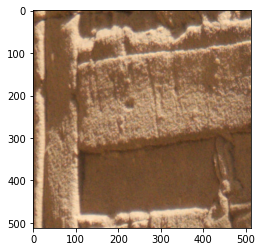

In [79]:
plt.imshow(images[0].permute(1, 2, 0).cpu())
plt.show()

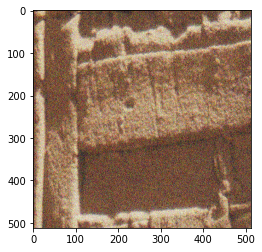

In [78]:
plt.imshow(adversarial_images[0].permute(1, 2, 0).cpu())
plt.show()